### Anshul Agrawal Student Id: 12211984 FX Carry Strategy

### Strategy Description:
    Below I have implemented an FX carry strategy which borrows in a (low-interest-rate) currency and lends in
    another currency (with high interest rates). I have assumed a fixed-float swap for doing the calculations. 
    The currencies used for analysis are Pakistani Rupee, Romanian Leu, US Dollar and Indonesian Rupiah.
    The position on a Notional of 10 mn USD is assumed every Wednesday of the week and closed by the next Wednesday.
    We are going into a levered transaction (Leverage 5x).
    I have fetched the data from Jan - 2015 because data of all major curves in all the currencies involved is available.

In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import datetime
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as st
import pandas_datareader.data as pdr
import warnings
warnings.filterwarnings('ignore')

In [17]:
quandl.ApiConfig.api_key = "_pYyj-4dy4nxthKZ9hr5"
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
    qdata = quandl.get(list(my_securities), returns = 'pandas', start_date="2015-01-01")
    return qdata

### Visualizing the evolution of 5Y rates of the countries involved in the analysis

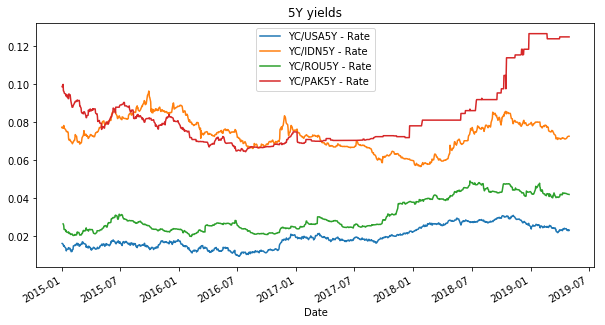

In [18]:
data = fetch_quandl(("YC/USA5Y","YC/IDN5Y","YC/ROU5Y","YC/PAK5Y"))/100
data = data.interpolate(axis = 0, method = 'index')
data.plot(figsize =(10,5))
plt.title("5Y yields")
plt.show()

In [19]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor > 0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [20]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0] == 0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, (zcb.T).values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

In [21]:
def carry_trade(ccy1,ccy2):
    
    #ccy 1 is the borrowing currency, ccy2 is the lending currency
    
    Notional = 10**7
    K = (1/5)*Notional                                                                           # Assuming 5x leverage
    leverage = Notional - K
    
    if ccy2 == 'PKR':
        fx_code = ("CUR/PKR",)
        yc_code = ("YC/PAK",)
        fgnswap = fetch_quandl(yc_code)
        fgnswap = fgnswap.iloc[:,0:5]/100
        fgnswap.columns = [3/12,6/12,12/12,3,5]
        fgnswap.interpolate(method = 'linear', inplace = True)
    
    elif ccy2 == 'RON':
        fx_code = ("CUR/RON",)
        yc_code = ("YC/ROU",)
        fgnswap = fetch_quandl(yc_code)
        fgnswap = fgnswap.iloc[:,0:4]/100
        fgnswap.columns = [6/12,12/12,3,5]
        fgnswap.interpolate(method = 'linear', inplace = True)
        
    else:
        fx_code = ("CUR/IDR",)
        yc_code = ("YC/IDN",)
        fgnswap = fetch_quandl(yc_code)
        fgnswap = fgnswap.iloc[:,0:5]/100
        fgnswap.columns = [1,2,3,4,5]
        fgnswap.interpolate(method = 'linear', inplace = True)
    
    domLibor = fetch_quandl(("YC/USA",))
    domLibor = domLibor[['YC/USA - 3-Month','YC/USA - 5-Year']]/100 
    domLibor.columns = [3/12,'US5Y-Rate']
    domLibor.interpolate(method = 'linear', inplace = True)
    
    domfgn = fetch_quandl(fx_code)
    
    dfborrow = domLibor.copy()
    dfborrow = pd.concat([domfgn,dfborrow], axis = 1)
    dfborrow['domAccrued_Float'] = 0 * len(dfborrow.index)
    dfborrow.columns = ['fx',0.25,'dom5Y-Rate','domAccrued_Float']
    dfborrow['domAccrued_Float'] = -1*leverage*(dfborrow[0.25]+50/10000)*(1/52)                     # 3-month LIBOR+50bp
    dfborrow = dfborrow.resample('W-WED').last()
    dfborrow['shifted_fx'] = dfborrow['fx'].shift(1).fillna(method = 'bfill')
    
    zcb = compute_zcb_curve(fgnswap.T)
    zcb.interpolate(method = 'linear', inplace = True)
    a = zcb.T.copy()
    b = fgnswap[5].copy()
    a = pd.concat([a,b], axis = 1)
    a = a.resample('W-WED').last()
    zcb2 = a.T.copy()
    
    dflent = zcb.T.copy()[[5]]
    dflent["Foreign_Bond_Price_Lent"] = 0 * len(dflent.index)
    dflent["Foreign_Bond_Price_Lent_1Wshifted"] = 0 * len(dflent.index)
    dflent = dflent.resample('W-WED').last()
    
    for i in range(0,len(zcb2.columns)-1):
        dflent.iloc[i,1] = bond_price(zcb2.iloc[0:len(zcb2.index)-1:,i],zcb2.iloc[len(zcb2.index)-1,i],5)
        dflent.iloc[i+1,2] = bond_price(zcb2.iloc[0:len(zcb2.index)-1:,i+1],zcb2.iloc[len(zcb2.index)-1,i],5-(1/52))

    dflent.columns = ['fgn5Y-Rate','fgn_BondPrice_Lent','fgn_BondPrice_Lent_1Wshifted']
    
    df = pd.concat([dfborrow,dflent], axis = 1)
    
    df['PnL_Fixed_Leg'] = Notional*((df['shifted_fx']*\
                            df['fgn_BondPrice_Lent_1Wshifted'])/(df['fx']*df['fgn_BondPrice_Lent'].shift(1))-1)
    
    df['Flag'] = 0 * len(df.index)
    df.loc[(abs(df['fgn5Y-Rate'] - df['dom5Y-Rate']) > 50/10000),'Flag'] = 1
    df['Flag_shifted'] = df['Flag'].shift(1).fillna(0)
    df.loc[(df['Flag_shifted'] == 0),'PnL_Fixed_Leg'] = 0
    
    df['domAccrued_Float'] = df['domAccrued_Float'].shift(1).fillna(0)
    df.loc[(df['Flag_shifted'] == 0),'domAccrued_Float'] = 0
    df['PnL_Fixed_Leg'].fillna(0, inplace = True)
    df['Total_PnL'] = df['domAccrued_Float'] + df['PnL_Fixed_Leg']
    
    df['Ret'] = df['Total_PnL']/K
    df['NegRet'] = df['Ret']
    df.loc[(df['Ret'] > 0),'NegRet'] = 0
    
    df['1YrRollingCumRet'] = (df['Total_PnL'].rolling(52).sum())/K
    df['1YrRollingSharpe'] = (df['Ret'].rolling(52).mean())/(df['Ret'].rolling(52).std())
    df['1YrRollingSortino'] = (df['Ret'].rolling(52).mean())/(df['NegRet'].rolling(52).std())
    
    return [df,domLibor,fgnswap]

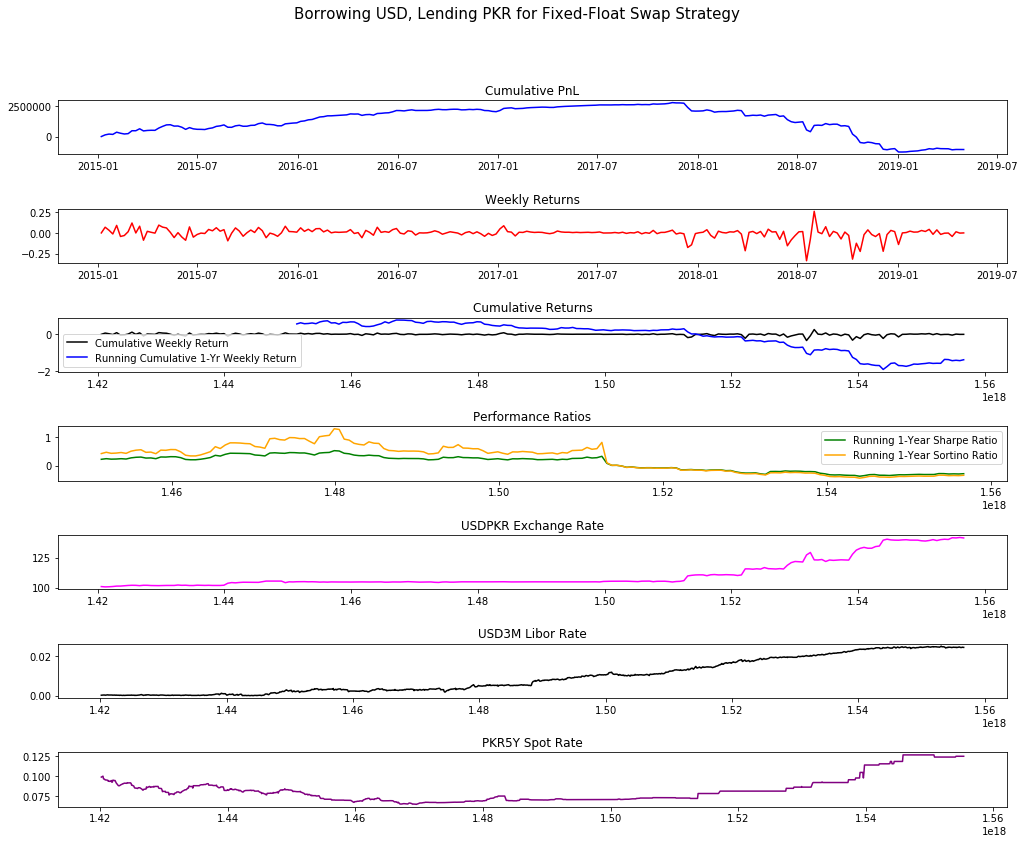

In [22]:
d = carry_trade('USD','PKR')
a = d[0]
b = d[1]
c = d[2]
Notional = 10**7
K = (1/5)*Notional
plt.figure(figsize=(17,13))
plt.suptitle('Borrowing {}, Lending {} for Fixed-Float Swap Strategy'.format('USD','PKR'),fontsize = 15)

plt.subplot(711)
plt.title('Cumulative PnL')
plt.plot(a['Total_PnL'].cumsum(),color='blue')
plt.subplots_adjust(hspace = 1)

plt.subplot(712)
plt.title('Weekly Returns')
plt.plot(a.Ret,color='red')
plt.subplots_adjust(hspace = 1)

plt.subplot(713)
plt.title('Cumulative Returns')
plt.plot(a.index.values.astype('d'), a.Total_PnL/K, color = 'black')
plt.plot(a.index.values.astype('d'), a['1YrRollingCumRet'], color = 'blue')
plt.subplots_adjust(hspace = 1)

plt.legend(['Cumulative Weekly Return','Running Cumulative 1-Yr Weekly Return'],loc = 'best')

plt.subplot(714)
plt.title('Performance Ratios')
plt.plot(a.index.values.astype('d'),a['1YrRollingSharpe'], color = 'green')
plt.plot(a.index.values.astype('d'),a['1YrRollingSortino'], color = 'orange')
plt.subplots_adjust(hspace = 1)

plt.legend(['Running 1-Year Sharpe Ratio','Running 1-Year Sortino Ratio'], loc='best')

plt.subplot(715)
plt.title('USDPKR Exchange Rate')
plt.plot(a.index.values.astype('d'),a['fx'], color='magenta')
plt.subplots_adjust(hspace = 1)

plt.subplot(716)
plt.title('USD3M Libor Rate')
plt.plot(b.index.values.astype('d'),b[0.25], color='black')
plt.subplots_adjust(hspace = 1)


plt.subplot(717)
plt.title('PKR5Y Spot Rate')
plt.plot(c.index.values.astype('d'),c[5], color='purple')
plt.subplots_adjust(hspace = 1)

### Conclusion:
    1) If the spread trade strategy is applied on the USD ( Borrowing Currency ) and Pakistan Rupee (PKR) ( Lending Currency )
    the the strategy initially performs well and we see postive returns in the period 2015-2018. This is primarily due to the fact that the exchange rate remained stable during the period which is very important for the strategy to generate alpha.Also the other reason for excess returns during this period was the rates (5Y) on Pakistani bond was greater than the borrowing rate.
    During the period 2018-2019 as the exchange rate started moving against our expectation ( weakening of the lending currency) the strategy started generated negative returns which is also evidenced by the fact that Sortino ratio is below the Sharpe ratio in that period.

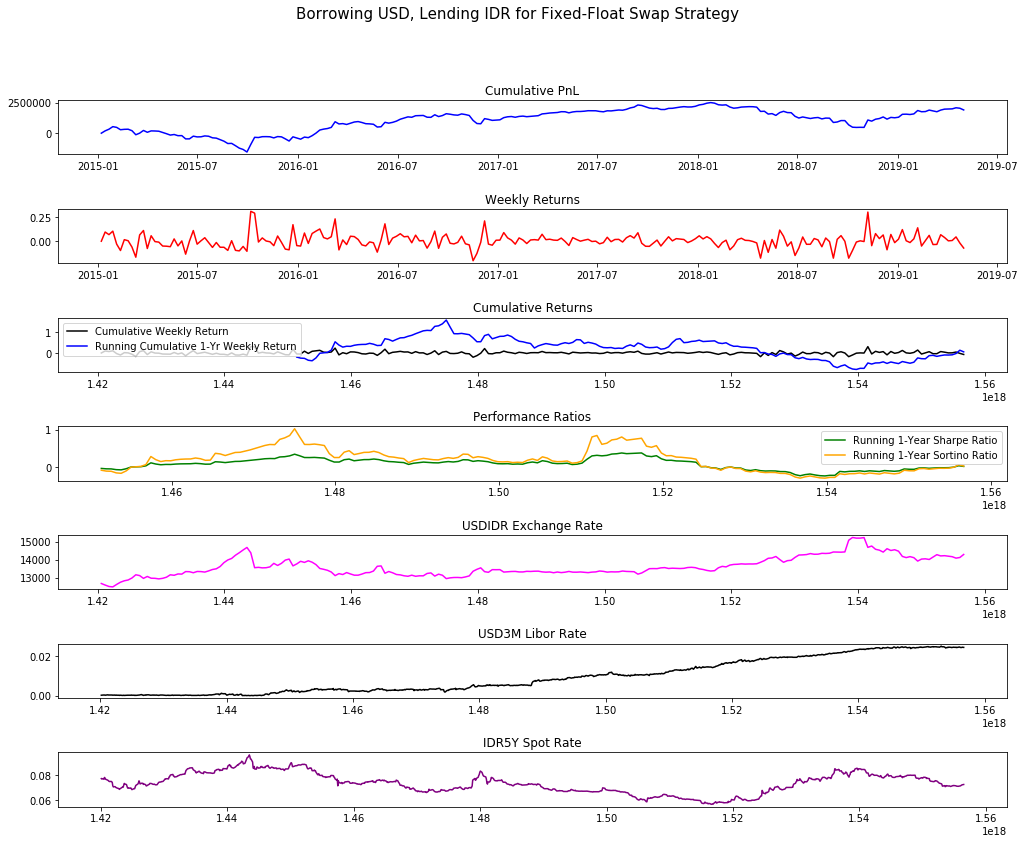

In [23]:
d = carry_trade('USD','IDR')
a = d[0]
b = d[1]
c = d[2]
Notional = 10**7
K = (1/5)*Notional
plt.figure(figsize=(17,13))
plt.suptitle('Borrowing {}, Lending {} for Fixed-Float Swap Strategy'.format('USD','IDR'),fontsize = 15)

plt.subplot(711)
plt.title('Cumulative PnL')
plt.plot(a['Total_PnL'].cumsum(),color='blue')
plt.subplots_adjust(hspace = 1)

plt.subplot(712)
plt.title('Weekly Returns')
plt.plot(a.Ret,color='red')
plt.subplots_adjust(hspace = 1)

plt.subplot(713)
plt.title('Cumulative Returns')
plt.plot(a.index.values.astype('d'), a.Total_PnL/K, color = 'black')
plt.plot(a.index.values.astype('d'), a['1YrRollingCumRet'], color = 'blue')
plt.subplots_adjust(hspace = 1)

plt.legend(['Cumulative Weekly Return','Running Cumulative 1-Yr Weekly Return'],loc = 'best')

plt.subplot(714)
plt.title('Performance Ratios')
plt.plot(a.index.values.astype('d'),a['1YrRollingSharpe'], color = 'green')
plt.plot(a.index.values.astype('d'),a['1YrRollingSortino'], color = 'orange')
plt.subplots_adjust(hspace = 1)

plt.legend(['Running 1-Year Sharpe Ratio','Running 1-Year Sortino Ratio'], loc='best')

plt.subplot(715)
plt.title('USDIDR Exchange Rate')
plt.plot(a.index.values.astype('d'),a['fx'], color='magenta')
plt.subplots_adjust(hspace = 1)

plt.subplot(716)
plt.title('USD3M Libor Rate')
plt.plot(b.index.values.astype('d'),b[0.25], color='black')
plt.subplots_adjust(hspace = 1)


plt.subplot(717)
plt.title('IDR5Y Spot Rate')
plt.plot(c.index.values.astype('d'),c[5], color='purple')
plt.subplots_adjust(hspace = 1)

### Conclusion:
    1) If the spread trade strategy is applied on the USD ( Borrowing Currency ) and Indonesion Rupee (PKR) (Lending Currency)
    the the strategy initially performs well and we see postive returns in the period 2016-2018. This is primarily due to the fact that the exchange rate remained stable during the period which is very important for the strategy to generate alpha.Also the other reason for excess returns during this period was the rates (5Y) on Indonesian bond was much greater than the borrowing rate and they kept on increasing whereas the USD Libor borrowing 3M rates remained the same.
    During the period 2018-2019 as the exchange rate started moving against our expectation ( weakening of the lending currency) the strategy started generated negative returns which is also evidenced by the fact that Sortino ratio is below the Sharpe ratio in that period.

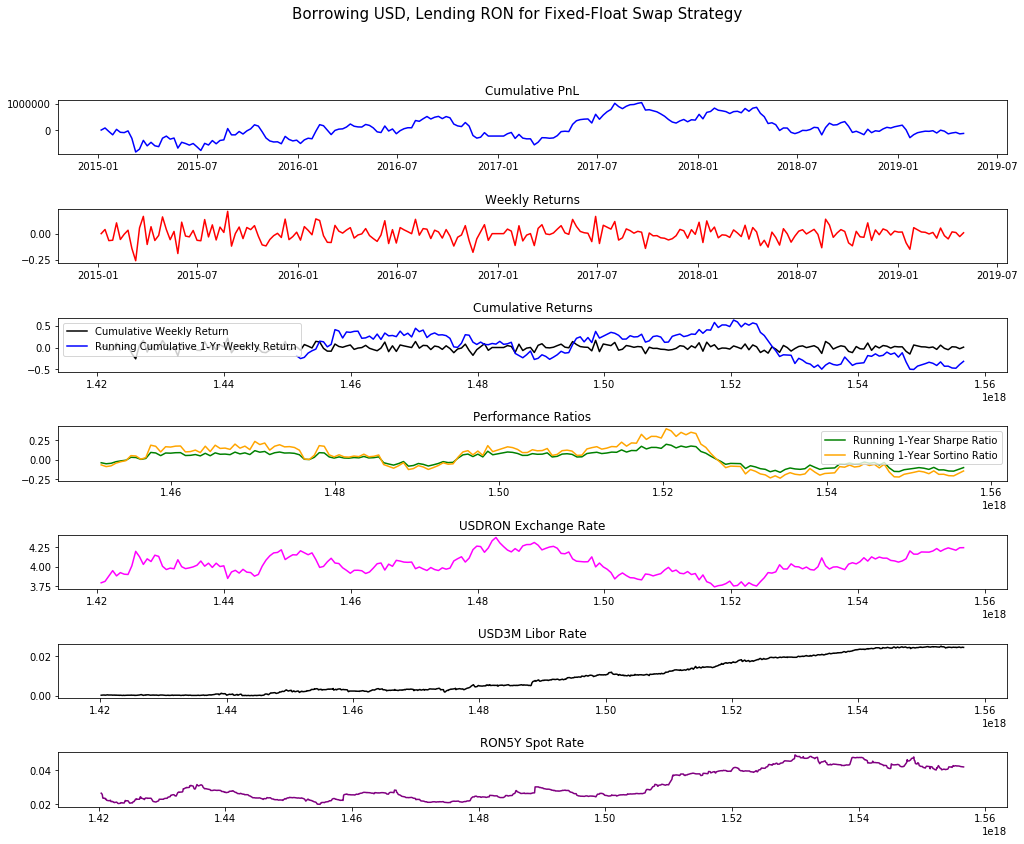

In [24]:
d = carry_trade('USD','RON')
a = d[0]
b = d[1]
c = d[2]
Notional = 10**7
K = (1/5)*Notional
plt.figure(figsize=(17,13))
plt.suptitle('Borrowing {}, Lending {} for Fixed-Float Swap Strategy'.format('USD','RON'),fontsize = 15)

plt.subplot(711)
plt.title('Cumulative PnL')
plt.plot(a['Total_PnL'].cumsum(),color='blue')
plt.subplots_adjust(hspace = 1)

plt.subplot(712)
plt.title('Weekly Returns')
plt.plot(a.Ret,color='red')
plt.subplots_adjust(hspace = 1)

plt.subplot(713)
plt.title('Cumulative Returns')
plt.plot(a.index.values.astype('d'), a.Total_PnL/K, color = 'black')
plt.plot(a.index.values.astype('d'), a['1YrRollingCumRet'], color = 'blue')
plt.subplots_adjust(hspace = 1)

plt.legend(['Cumulative Weekly Return','Running Cumulative 1-Yr Weekly Return'],loc = 'best')

plt.subplot(714)
plt.title('Performance Ratios')
plt.plot(a.index.values.astype('d'),a['1YrRollingSharpe'], color = 'green')
plt.plot(a.index.values.astype('d'),a['1YrRollingSortino'], color = 'orange')
plt.subplots_adjust(hspace = 1)

plt.legend(['Running 1-Year Sharpe Ratio','Running 1-Year Sortino Ratio'], loc='best')

plt.subplot(715)
plt.title('USDRON Exchange Rate')
plt.plot(a.index.values.astype('d'),a['fx'], color='magenta')
plt.subplots_adjust(hspace = 1)

plt.subplot(716)
plt.title('USD3M Libor Rate')
plt.plot(b.index.values.astype('d'),b[0.25], color='black')
plt.subplots_adjust(hspace = 1)

plt.subplot(717)
plt.title('RON5Y Spot Rate')
plt.plot(c.index.values.astype('d'),c[5], color='purple')
plt.subplots_adjust(hspace = 1)

### Conclusion:
    1) If the spread trade strategy is applied on the USD ( Borrowing Currency ) and Romanian Lieu(RON) (Lending Currency)
    the the strategy initially performs well and we see postive returns in the period 2017-2018. This is primarily due to the fact that the exchange rate took a hit remained stable during the period which is very important for the strategy to generate alpha.
    During the period 2018-2019 as the exchange rate started moving against our expectation ( weakening of the lending currency) the strategy started generated negative returns which is also evidenced by the fact that Sortino ratio is below the Sharpe ratio in that period.

## Statistical Indicators of Carry Trades

### Good Carry Trade Characteristics 
    
    1) More frequent positive returns
    2) Negative Return skew with a fatter left tail than right tail in the return histogram
    3) Positive correlation to broad market indicators
    4) Negative correlation to the fear indicators like VIX.
    5) High Excess Kurtosis of Returns

### Statistical Analysis on USD/RON currency pair 

Return Series Statistics

count    226.000000
mean      -0.000281
std        0.069717
min       -0.259571
25%       -0.043037
50%        0.000496
75%        0.039290
max        0.214051
Name: Ret, dtype: float64 

*******************************************************************************

-0.11805346849632366    Skewness
3.789456577990623   Kurtosis
-0.022299684049945822 Return - SPX Correlation
0.008281466800029771 Return - VIX Correlation


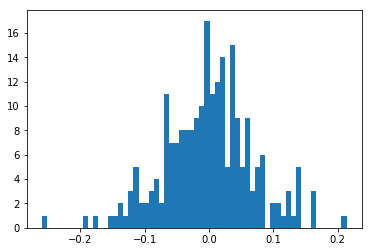

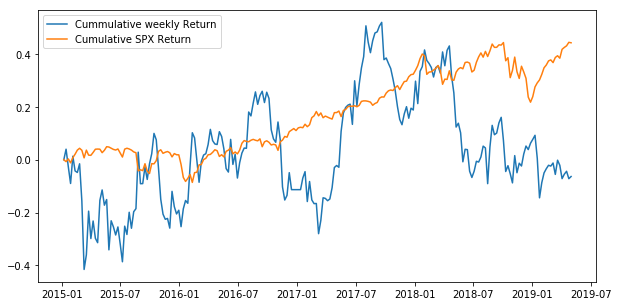

In [25]:
d = carry_trade('USD','RON')
a = d[0]

print("Return Series Statistics\n")
print(a['Ret'].describe(),"\n")
print("*******************************************************************************\n")
print(st.skew(a['Ret']),'   Skewness')
print(st.kurtosis(a['Ret'], fisher = False), '  Kurtosis')

plt.hist(a['Ret'], bins = 60)

vix = pdr.DataReader('^VIX', 'yahoo', start='2015-01-01')
vix = vix.resample('W-WED', how = 'last').fillna(method="ffill")["Adj Close"]

spx = pdr.DataReader('^GSPC', 'yahoo', start='2015-01-01')
spx = spx.resample('W-WED', how = 'last').fillna(method="ffill")["Adj Close"]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(a.index,a['Ret'].cumsum(),label = "Cummulative weekly Return")
ax.plot((spx/spx[0]-1),label = "Cumulative SPX Return")
plt.legend()

print(a['Ret'].corr(spx, method = 'pearson'),"Return - SPX Correlation")
print(a['Ret'].corr(vix, method = 'pearson'),"Return - VIX Correlation")

plt.show()

### Conclusion:
    1) So as we observe from the above statistics , psotive returns are more than the negative returns and the distribution has 
    a slight fat left tail. Correlation with the broad indicator is close to 0 which is a little undesirable.
    Correlation with fear index VIX is also close to 0 which is good for our strategy.

### Statistical Analysis on USD/PAK pair

Return Series Statistics

count    226.000000
mean      -0.002363
std        0.058602
min       -0.334368
25%       -0.009363
50%        0.005887
75%        0.017821
max        0.259783
Name: Ret, dtype: float64 

*******************************************************************************

-2.0017228392514457    Skewness
13.91101066652289   Kurtosis
-0.25043717354066486 Return - SPX Correlation
-0.07480651264785831 Return - VIX Correlation


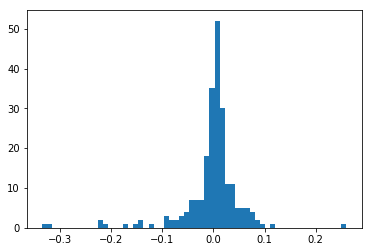

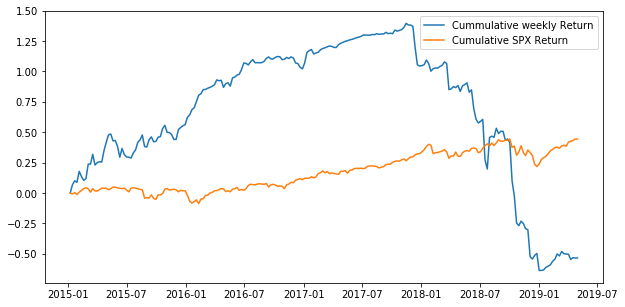

In [26]:
d = carry_trade('USD','PKR')
a = d[0]

print("Return Series Statistics\n")
print(a['Ret'].describe(),"\n")
print("*******************************************************************************\n")
print(st.skew(a['Ret']),'   Skewness')
print(st.kurtosis(a['Ret'], fisher = False), '  Kurtosis')

plt.hist(a['Ret'], bins = 60)

vix = pdr.DataReader('^VIX', 'yahoo', start='2015-01-01')
vix = vix.resample('W-WED', how = 'last').fillna(method="ffill")["Adj Close"]

spx = pdr.DataReader('^GSPC', 'yahoo', start='2015-01-01')
spx = spx.resample('W-WED', how = 'last').fillna(method="ffill")["Adj Close"]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(a.index,a['Ret'].cumsum(),label = "Cummulative weekly Return")
ax.plot((spx/spx[0]-1),label = "Cumulative SPX Return")
plt.legend()

print(a['Ret'].corr(spx, method = 'pearson'),"Return - SPX Correlation")
print(a['Ret'].corr(vix, method = 'pearson'),"Return - VIX Correlation")

plt.show()

### Conclusion:
    
    1) So as we observe from the above statistics , positive returns outnumber the negative returns and the distribution has 
    a big fat left tail. 
    Correlation with fear index VIX is negative which is extremely desirable as our strategy performs well when the market is spooked.  So carry trade on USD/PAK pair looks attractive but the tables start turning on the strategy when the PAK currency starts depreciating. 

### Statistical Analysis on USD/IDR pair

Return Series Statistics

count    226.000000
mean       0.004193
std        0.072024
min       -0.201440
25%       -0.032567
50%        0.004107
75%        0.034576
max        0.308908
Name: Ret, dtype: float64 

*******************************************************************************

0.8161544914440745    Skewness
6.619497028598099   Kurtosis
-0.06409439941480263 Return - SPX Correlation
-0.022866728115603002 Return - VIX Correlation


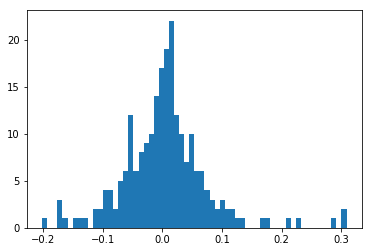

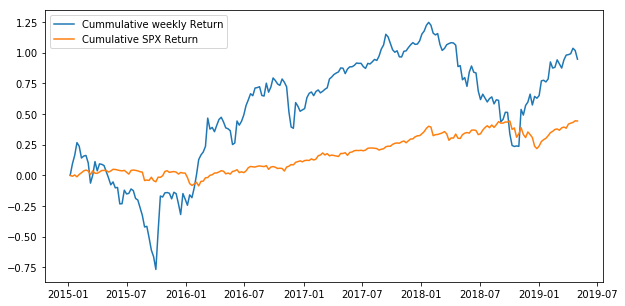

In [27]:
d = carry_trade('USD','IDR')
a = d[0]

print("Return Series Statistics\n")
print(a['Ret'].describe(),"\n")
print("*******************************************************************************\n")
print(st.skew(a['Ret']),'   Skewness')
print(st.kurtosis(a['Ret'], fisher = False), '  Kurtosis')

plt.hist(a['Ret'], bins = 60)

vix = pdr.DataReader('^VIX', 'yahoo', start='2015-01-01')
vix = vix.resample('W-WED', how = 'last').fillna(method="ffill")["Adj Close"]

spx = pdr.DataReader('^GSPC', 'yahoo', start='2015-01-01')
spx = spx.resample('W-WED', how = 'last').fillna(method="ffill")["Adj Close"]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(a.index,a['Ret'].cumsum(),label = "Cummulative weekly Return")
ax.plot((spx/spx[0]-1),label = "Cumulative SPX Return")
plt.legend()

print(a['Ret'].corr(spx, method = 'pearson'),"Return - SPX Correlation")
print(a['Ret'].corr(vix, method = 'pearson'),"Return - VIX Correlation")

plt.show()

### Conclusion:
    
    1) So as we observe from the above statistics , positive returns outnumber the negative returns and the distribution has 
    a big fat tails. 
    Correlation with fear index VIX is negative which is extremely desirable as our strategy performs well when the market is spooked.  So carry trade on USD/IDR pair looks attractive but the tables start turning on the strategy when the IDR currency starts depreciating.